In [1]:
# !pip install numpy
# !pip install pandas
# !pip install  rdkit
# !pip install networkx

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 5.4 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.7/12.7 MB 3.2 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.1/33.1 MB 6.3 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 4.4 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 694.1 kB/s eta 0:00:000:00:01


In [ ]:
#just run this code to create molcules graphs !!!!!! 

In [4]:
import pandas as pd 

pd.read_csv("filtered_KibaDataSet.csv")

,Drug_ID,Drug,Target_ID,Target,Y
0,CHEMBL1087421,COc1cc2c(cc1Cl)C(c1ccc(Cl)c(Cl)c1)=NCC2,O00141,MTVKTEAAKGTLTYSRMRGMVAILIAFMKQRRMGLNDFIQKIANNS...,11.10000
1,CHEMBL1087421,COc1cc2c(cc1Cl)C(c1ccc(Cl)c(Cl)c1)=NCC2,O14920,MSWSPSLTTQTCGAWEMKERLGTGGFGNVIRWHNQETGEQIAIKQC...,11.10000
2,CHEMBL1087421,COc1cc2c(cc1Cl)C(c1ccc(Cl)c(Cl)c1)=NCC2,O15111,MERPPGLRPGAGGPWEMRERLGTGGFGNVCLYQHRELDLKIAIKSC...,11.10000
3,CHEMBL1087421,COc1cc2c(cc1Cl)C(c1ccc(Cl)c(Cl)c1)=NCC2,P06239,MGCGCSSHPEDDWMENIDVCENCHYPIVPLDGKGTLLIRNGSEVRD...,11.10000
4,CHEMBL1087421,COc1cc2c(cc1Cl)C(c1ccc(Cl)c(Cl)c1)=NCC2,P07333,MGPGVLLLLLVATAWHGQGIPVIEPSVPELVVKPGATVTLRCVGNG...,11.10000
...,...,...,...,...,...
101204,CHEMBL230654,CCCc1nc[nH]c1CNc1cc(Cl)c2ncc(C#N)c(Nc3ccc(F)c(...,Q13554,MATTVTCTRFTDEYQLYEDIGKGAFSVVRRCVKLCTGHEYAAKIIN...,10.49794
101205,CHEMBL230654,CCCc1nc[nH]c1CNc1cc(Cl)c2ncc(C#N)c(Nc3ccc(F)c(...,Q13555,MATTATCTRFTDDYQLFEELGKGAFSVVRRCVKKTSTQEYAAKIIN...,10.49794
101206,CHEMBL230654,CCCc1nc[nH]c1CNc1cc(Cl)c2ncc(C#N)c(Nc3ccc(F)c(...,Q13557,MASTTTCTRFTDEYQLFEELGKGAFSVVRRCMKIPTGQEYAAKIIN...,10.49794
101207,CHEMBL230654,CCCc1nc[nH]c1CNc1cc(Cl)c2ncc(C#N)c(Nc3ccc(F)c(...,Q16539,MSQERPTFYRQELNKTIWEVPERYQNLSPVGSGAYGSVCAAFDTKT...,10.49794


In [8]:
import os
import numpy as np
import pandas as pd

def load_and_prepare_data_from_csv(csv_path, dataset_name):
    # Create directories
    dataset_dir = dataset_name
    proteins_dir = os.path.join(dataset_dir, 'proteins')
    molecules_dir = os.path.join(dataset_dir, 'molecules')
    
    os.makedirs(proteins_dir, exist_ok=True)
    os.makedirs(molecules_dir, exist_ok=True)
    
    # Load the CSV file
    data = pd.read_csv(csv_path)

    # Process and save proteins in FASTA format
    for index, row in data.iterrows():
        protein_id = row['Target_ID']
        sequence = row['Target']
        fasta_file = os.path.join(proteins_dir, f"{protein_id}.fasta")
        with open(fasta_file, 'w') as f:
            f.write(f">{protein_id}\n")
            # Split the sequence into 60-character lines, as is typical in FASTA format
            for i in range(0, len(sequence), 60):
                f.write(sequence[i:i+60] + "\n")

    # Process and save molecules (SMILES) in .npy format
    for index, row in data.iterrows():
        chembl_id = row['Drug_ID']
        smiles = row['Drug']
        npy_file = os.path.join(molecules_dir, f"{chembl_id}.npy")
        np.save(npy_file, smiles)

    # Prepare affinity data
    affinity_data = []
    for index, row in data.iterrows():
        protein_id = row['Target_ID']
        chembl_id = row['Drug_ID']
        affinity_value = row['Y']
        affinity_data.append((protein_id, chembl_id, affinity_value))
    
    # Save affinity data
    np.save(os.path.join(dataset_dir, 'affinity_data.npy'), affinity_data)

# Example usage:
csv_path = 'filtered_KibaDataSet.csv'  # Path to the KIBA CSV file
load_and_prepare_data_from_csv(csv_path, 'kiba_dataset')


In [12]:
import os
import numpy as np
from rdkit import Chem
import networkx as nx

def create_molecule_graphs(molecule_dir):
    molecule_graphs = []

    for filename in os.listdir(molecule_dir):
        if filename.endswith('.npy'):
            # Load SMILES string from the .npy file and convert to string
            file_path = os.path.join(molecule_dir, filename)
            smiles = np.load(file_path, allow_pickle=True)  # Load the numpy file

            if isinstance(smiles, np.ndarray):  # If it is a numpy array
                smiles = smiles.item()  # Convert numpy object to string if necessary

            # Convert SMILES to RDKit molecule object
            mol = Chem.MolFromSmiles(smiles)
            if mol is None:
                print(f"Invalid SMILES: {smiles} in {filename}")
                continue

            num_atoms = mol.GetNumAtoms()

            # Extract atom features for each atom in the molecule
            atom_list = ['C', 'N', 'O', 'S', 'F', 'Si', 'P', 'Cl', 'Br', 'Mg', 'Na', 'Ca', 
                         'Fe', 'As', 'Al', 'I', 'B', 'V', 'K', 'Tl', 'Yb', 'Sb', 'Sn', 
                         'Ag', 'Pd', 'Co', 'Se', 'Ti', 'Zn', 'H', 'Li', 'Ge', 'Cu', 
                         'Au', 'Ni', 'Cd', 'In', 'Mn', 'Zr', 'Cr', 'Pt', 'Hg', 'Pb', 'X']

            features = []
            for atom in mol.GetAtoms():
                # One-hot encoding of atom type
                atom_encoding = [1 if atom.GetSymbol() == atom_type else 0 for atom_type in atom_list]

                # One-hot encoding of atom degree (number of neighbors)
                degree_encoding = [1 if atom.GetDegree() == i else 0 for i in range(11)]

                # One-hot encoding of number of explicit hydrogens
                num_H_encoding = [1 if atom.GetTotalNumHs() == i else 0 for i in range(11)]

                # One-hot encoding of number of implicit hydrogens
                implicit_H_encoding = [1 if atom.GetImplicitValence() == i else 0 for i in range(11)]

                # Whether the atom is aromatic (1 or 0)
                aromatic_encoding = [1 if atom.GetIsAromatic() else 0]

                # Concatenate all features (78-dimensional feature vector)
                feature_vector = atom_encoding + degree_encoding + num_H_encoding + implicit_H_encoding + aromatic_encoding
                features.append(feature_vector)

            # Create edges from bond information
            edges = []
            for bond in mol.GetBonds():
                i = bond.GetBeginAtomIdx()
                j = bond.GetEndAtomIdx()
                edges.append([i, j])

            # Create a directed graph from the edges
            g = nx.Graph(edges).to_directed()
            edge_index = np.array([[i, j] for i, j in g.edges])

            # Append graph data (number of atoms, features, edges) for each molecule
            molecule_graphs.append({
                'num_atoms': num_atoms,
                'features': np.array(features),
                'edge_index': edge_index,
                'smiles': smiles
            })

    return molecule_graphs

# Example usage:
molecule_dir = 'kiba_dataset/molecules'
molecule_graphs = create_molecule_graphs(molecule_dir)

# Print details of the first molecule graph
print("First molecule graph:")
print("Number of atoms:", molecule_graphs[0]['num_atoms'])
print("Features:", molecule_graphs[0]['features'])
print("Edge index:", molecule_graphs[0]['edge_index'])
print("SMILES:", molecule_graphs[0]['smiles'])


First molecule graph:
Number of atoms: 21
Features: [[0 0 1 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 ...
 [1 0 0 ... 0 0 1]
 [1 0 0 ... 0 0 1]
 [0 1 0 ... 0 0 1]]
Edge index: [[ 0  1]
 [ 1  0]
 [ 1  2]
 [ 1 13]
 [ 2  1]
 [ 2  3]
 [ 2 10]
 [ 3  2]
 [ 3  4]
 [ 4  3]
 [ 4  5]
 [ 4  9]
 [ 5  4]
 [ 5  6]
 [ 6  5]
 [ 6  7]
 [ 7  6]
 [ 7  8]
 [ 8  7]
 [ 8  9]
 [ 9  8]
 [ 9  4]
 [10  2]
 [10 11]
 [11 10]
 [11 12]
 [12 11]
 [12 13]
 [13 12]
 [13 14]
 [13  1]
 [14 13]
 [14 15]
 [15 14]
 [15 16]
 [15 20]
 [16 15]
 [16 17]
 [17 16]
 [17 18]
 [18 17]
 [18 19]
 [19 18]
 [19 20]
 [20 19]
 [20 15]]
SMILES: O=C1C(=Cc2ccccn2)CNCC1=Cc1ccccn1


In [14]:
# Checking the feature set dimensions for the first molecule
first_molecule_features = molecule_graphs[0]['features']

# Print the shape of the feature set
print("Shape of the feature set for each atom (Number of atoms, Feature vector size):", first_molecule_features.shape)


Shape of the feature set for each atom (Number of atoms, Feature vector size): (21, 78)


In [15]:
# !pip install matplotlib

In [19]:
import os
import pickle
import numpy as np
from rdkit import Chem
import networkx as nx

# Create molecule graphs from SMILES and save with Drug_ID
def create_and_save_molecule_graphs(csv_path, molecule_save_dir):
    # Create the directory for saving molecule graphs if it doesn't exist
    os.makedirs(molecule_save_dir, exist_ok=True)
    
    # Load the CSV file
    data = pd.read_csv(csv_path)
    
    for index, row in data.iterrows():
        chembl_id = row['Drug_ID']
        smiles = row['Drug']
        
        # Convert SMILES to RDKit molecule object
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            print(f"Invalid SMILES: {smiles} for {chembl_id}")
            continue
        
        num_atoms = mol.GetNumAtoms()
        
        # Extract atom features for each atom in the molecule
        atom_list = ['C', 'N', 'O', 'S', 'F', 'Si', 'P', 'Cl', 'Br', 'Mg', 'Na', 'Ca', 
                     'Fe', 'As', 'Al', 'I', 'B', 'V', 'K', 'Tl', 'Yb', 'Sb', 'Sn', 
                     'Ag', 'Pd', 'Co', 'Se', 'Ti', 'Zn', 'H', 'Li', 'Ge', 'Cu', 
                     'Au', 'Ni', 'Cd', 'In', 'Mn', 'Zr', 'Cr', 'Pt', 'Hg', 'Pb', 'X']
        
        features = []
        for atom in mol.GetAtoms():
            # One-hot encoding of atom type
            atom_encoding = [1 if atom.GetSymbol() == atom_type else 0 for atom_type in atom_list]

            # One-hot encoding of atom degree (number of neighbors)
            degree_encoding = [1 if atom.GetDegree() == i else 0 for i in range(11)]

            # One-hot encoding of number of explicit hydrogens
            num_H_encoding = [1 if atom.GetTotalNumHs() == i else 0 for i in range(11)]

            # One-hot encoding of number of implicit hydrogens
            implicit_H_encoding = [1 if atom.GetImplicitValence() == i else 0 for i in range(11)]

            # Whether the atom is aromatic (1 or 0)
            aromatic_encoding = [1 if atom.GetIsAromatic() else 0]

            # Concatenate all features (78-dimensional feature vector)
            feature_vector = atom_encoding + degree_encoding + num_H_encoding + implicit_H_encoding + aromatic_encoding
            features.append(feature_vector)

        # Create edges from bond information
        edges = []
        for bond in mol.GetBonds():
            i = bond.GetBeginAtomIdx()
            j = bond.GetEndAtomIdx()
            edges.append([i, j])

        # Create a directed graph from the edges
        g = nx.Graph(edges).to_directed()
        edge_index = np.array([[i, j] for i, j in g.edges])

        # Save the molecule graph
        molecule_graph = {
            'num_atoms': num_atoms,
            'features': np.array(features),
            'edge_index': edge_index,
            'smiles': smiles
        }
        
        # Save the graph using the Drug_ID as filename
        graph_save_path = os.path.join(molecule_save_dir, f"{chembl_id}_graph.pkl")
        with open(graph_save_path, 'wb') as f:
            pickle.dump(molecule_graph, f)
    
    print(f"Saved all molecule graphs to {molecule_save_dir}")

# Example usage:
csv_path = 'filtered_KibaDataSet.csv'  # Path to the KIBA CSV file
molecule_save_dir = 'molecule_graphs'  # Directory where the molecule graphs will be saved
create_and_save_molecule_graphs(csv_path, molecule_save_dir)


Saved all molecule graphs to molecule_graphs


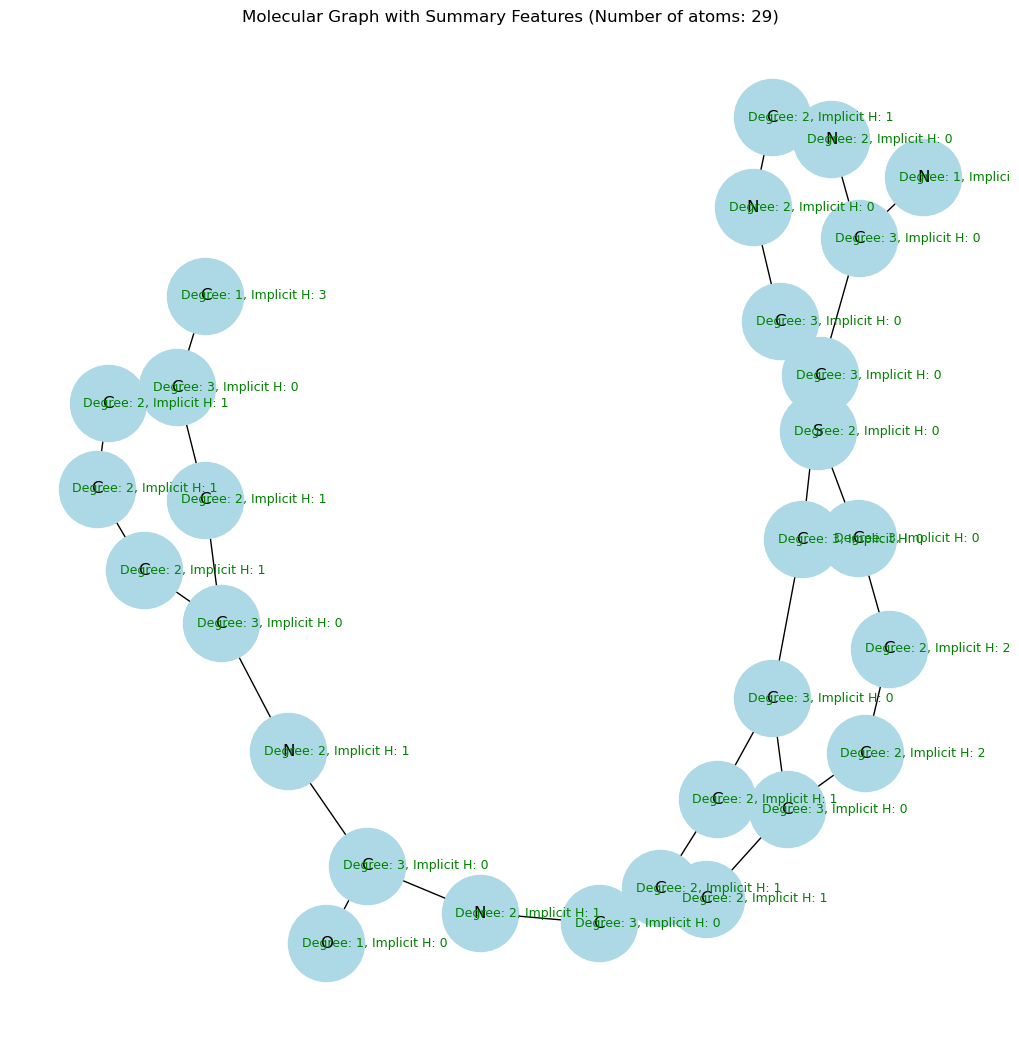

In [20]:
import os
import pickle
import matplotlib.pyplot as plt
import networkx as nx

# Function to load the saved molecule graph
def load_molecule_graph(graph_file):
    with open(graph_file, 'rb') as f:
        molecule_graph = pickle.load(f)
    return molecule_graph

# Function to plot the molecule graph with features
def plot_molecule_graph_with_summary_features(molecule_graph):
    G = nx.Graph()

    # Add nodes (atoms) to the graph
    atom_labels = {}  # Labels for atom types inside the nodes
    feature_summary_labels = {}  # Labels for feature set summaries outside the nodes

    for i in range(molecule_graph['num_atoms']):
        G.add_node(i)

        # Get the atom type from the first 44 dimensions of the feature vector
        atom_type_index = molecule_graph['features'][i][:44].argmax()
        atom_list = ['C', 'N', 'O', 'S', 'F', 'Si', 'P', 'Cl', 'Br', 'Mg', 'Na', 'Ca', 
                     'Fe', 'As', 'Al', 'I', 'B', 'V', 'K', 'Tl', 'Yb', 'Sb', 'Sn', 
                     'Ag', 'Pd', 'Co', 'Se', 'Ti', 'Zn', 'H', 'Li', 'Ge', 'Cu', 
                     'Au', 'Ni', 'Cd', 'In', 'Mn', 'Zr', 'Cr', 'Pt', 'Hg', 'Pb', 'X']
        atom_type = atom_list[atom_type_index]

        # Get the key summary of the feature set (atom type and degree)
        degree = molecule_graph['features'][i][44:55].argmax()  # Atom degree
        implicit_H = molecule_graph['features'][i][55:66].argmax()  # Implicit Hydrogens

        # Atom type label inside the node
        atom_labels[i] = atom_type

        # Summary of features next to the node
        feature_summary_labels[i] = f"Degree: {degree}, Implicit H: {implicit_H}"

    # Add edges (bonds) between atoms
    for edge in molecule_graph['edge_index']:
        G.add_edge(edge[0], edge[1])

    # Generate layout for graph nodes
    pos = nx.spring_layout(G, seed=42)  # Positions for all nodes (seed for reproducibility)

    plt.figure(figsize=(10, 10))

    # Draw the nodes (atoms) and edges (bonds)
    nx.draw(G, pos, with_labels=False, node_color='lightblue', node_size=3000, font_size=10, font_color='black', font_weight='bold')

    # Draw the atom type inside the node
    nx.draw_networkx_labels(G, pos, atom_labels, font_size=12, font_color='black')

    # Offset the feature summary labels so they don't overlap with the nodes
    pos_features = {k: (v[0] + 0.1, v[1]) for k, v in pos.items()}  # Shift feature labels slightly to the right

    # Draw the feature summary (degree and implicit H count) next to each node
    nx.draw_networkx_labels(G, pos_features, feature_summary_labels, font_size=9, font_color='green')

    plt.title(f"Molecular Graph with Summary Features (Number of atoms: {molecule_graph['num_atoms']})")

    # Explicitly call show() to display the plot
    plt.show()

# Directory where the molecule graphs are stored
molecule_graph_dir = './molecule_graphs'

# Example usage to plot one of the molecule graphs
graph_file = os.path.join(molecule_graph_dir, "CHEMBL1242373_graph.pkl")  # Replace with the correct filename
molecule_graph = load_molecule_graph(graph_file)
plot_molecule_graph_with_summary_features(molecule_graph)


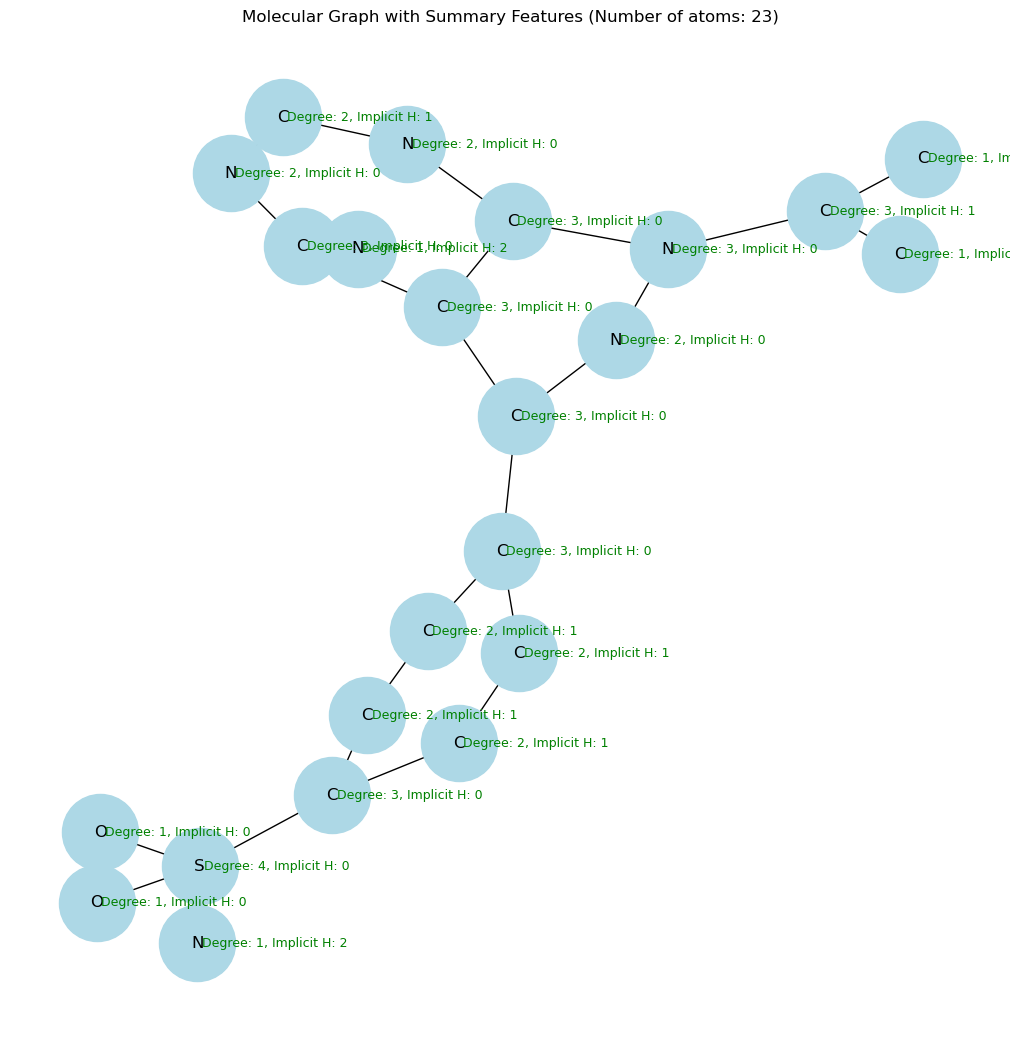

In [16]:
import matplotlib.pyplot as plt
import networkx as nx

def plot_molecule_graph_with_summary_features(molecule_graph):
    G = nx.Graph()
    
    # Add nodes (atoms) to the graph
    atom_labels = {}  # Labels for atom types inside the nodes
    feature_summary_labels = {}  # Labels for feature set summaries outside the nodes
    
    for i in range(molecule_graph['num_atoms']):
        G.add_node(i)
        
        # Get the atom type from the first 44 dimensions of the feature vector
        atom_type_index = molecule_graph['features'][i][:44].argmax()
        atom_list = ['C', 'N', 'O', 'S', 'F', 'Si', 'P', 'Cl', 'Br', 'Mg', 'Na', 'Ca', 
                     'Fe', 'As', 'Al', 'I', 'B', 'V', 'K', 'Tl', 'Yb', 'Sb', 'Sn', 
                     'Ag', 'Pd', 'Co', 'Se', 'Ti', 'Zn', 'H', 'Li', 'Ge', 'Cu', 
                     'Au', 'Ni', 'Cd', 'In', 'Mn', 'Zr', 'Cr', 'Pt', 'Hg', 'Pb', 'X']
        atom_type = atom_list[atom_type_index]
        
        # Get the key summary of the feature set (atom type and degree)
        degree = molecule_graph['features'][i][44:55].argmax()  # Atom degree
        implicit_H = molecule_graph['features'][i][55:66].argmax()  # Implicit Hydrogens
        
        # Atom type label inside the node
        atom_labels[i] = atom_type
        
        # Summary of features next to the node
        feature_summary_labels[i] = f"Degree: {degree}, Implicit H: {implicit_H}"

    # Add edges (bonds) between atoms
    for edge in molecule_graph['edge_index']:
        G.add_edge(edge[0], edge[1])

    # Generate layout for graph nodes
    pos = nx.spring_layout(G, seed=42)  # Positions for all nodes (seed for reproducibility)
    
    plt.figure(figsize=(10, 10))
    
    # Draw the nodes (atoms) and edges (bonds)
    nx.draw(G, pos, with_labels=False, node_color='lightblue', node_size=3000, font_size=10, font_color='black', font_weight='bold')
    
    # Draw the atom type inside the node
    nx.draw_networkx_labels(G, pos, atom_labels, font_size=12, font_color='black')
    
    # Offset the feature summary labels so they don't overlap with the nodes
    pos_features = {k: (v[0] + 0.1, v[1]) for k, v in pos.items()}  # Shift feature labels slightly to the right
    
    # Draw the feature summary (degree and implicit H count) next to each node
    nx.draw_networkx_labels(G, pos_features, feature_summary_labels, font_size=9, font_color='green')
    
    plt.title(f"Molecular Graph with Summary Features (Number of atoms: {molecule_graph['num_atoms']})")
    
    # Explicitly call show() to display the plot
    plt.show()

# Example usage to plot the first molecule graph:
plot_molecule_graph_with_summary_features(molecule_graphs[20])


In [17]:
import os
import pickle
import networkx as nx

def save_molecule_graphs(molecule_graphs, save_dir="molecule_graphs"):
    # Create the directory if it does not exist
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    # Save each molecular graph as a pickle file
    for i, molecule_graph in enumerate(molecule_graphs):
        save_path = os.path.join(save_dir, f"molecule_graph_{i}.pkl")
        with open(save_path, 'wb') as f:
            pickle.dump(molecule_graph, f)

    print(f"Saved {len(molecule_graphs)} molecular graphs to {save_dir}")

# Example usage to save the graphs:
save_molecule_graphs(molecule_graphs)


Saved 2111 molecular graphs to molecule_graphs
